In [1]:
# import libraries
import os
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision import transforms
import torchvision.models
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader

In [2]:
# create dataset class for AffectNet
class AffectNetImageDataset(Dataset):
    """AffectNet Facial Expressions Dataset"""

    def __init__(self, annotations_file, img_dir, transform=None):
        """
        Args:
            annotations_file: Path to the csv file with annotations.
            img_dir: Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        return image, label

# resize all images to 224 x 224
transform = transforms.Compose([transforms.CenterCrop(224)])

train_data = AffectNetImageDataset(annotations_file='./data/train_set/annotations/labels.csv',
                                   img_dir='./data/train_set/images/',
                                   transform=transform)
val_data = AffectNetImageDataset(annotations_file='./data/val_set/annotations/labels.csv',
                                   img_dir='./data/val_set/images/',
                                   transform=transform)

# print out some data stats
print('Num training images: ', len(train_data))
print('Num validation images: ', len(val_data))

Num training images:  52500
Num validation images:  980


In [3]:
# create dataloader for AffectNet
###########################################################
# put this in training function if batch_size is a training fuction parameter
###########################################################
def get_data_loader(data, batch_size=64, num_workers=16):
    data_loader = DataLoader(data, batch_size=batch_size, num_workers=num_workers, shuffle=True, pin_memory=True)
    return data_loader

# Fixed PyTorch random seed for reproducible result
torch.manual_seed(1000)

# Obtain the PyTorch data loader objects to load batches of the datasets
train_loader = get_data_loader(train_data, batch_size=64, num_workers=16)
val_loader = get_data_loader(val_data, batch_size=64, num_workers=16)

/tmp/ipykernel_77579/533008091.py:13: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])


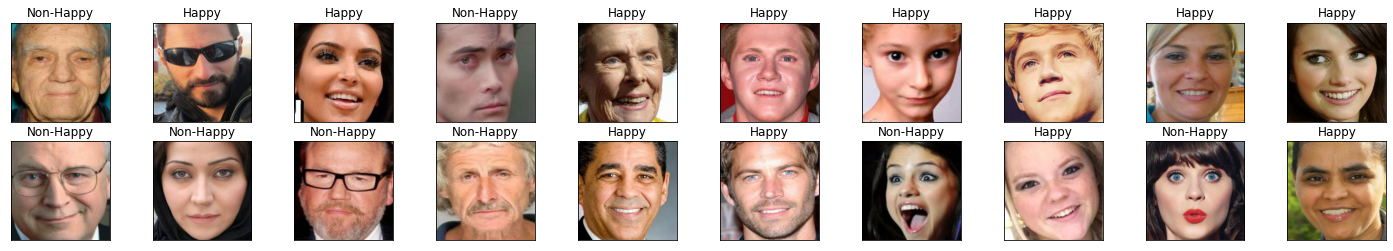

In [4]:
# Visualize some sample data
labels_encoder_binary = {0: "Non-Happy", 1: "Happy"}

# obtain one batch of training images
dataiter = iter(val_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display
labels = labels.numpy() # convert labels to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(labels_encoder_binary[labels[idx]])

In [9]:
def get_feature_loader(pretrained_model, data, batch_size=64, num_workers=16):
    '''
    Extract convolutional features from a dataset with a pretrained model method.
    Then, generate a feature loader as (features, labels).
    '''
    # Obtain the PyTorch data loader object to load batches of the dataset
    data_loader = get_data_loader(data, batch_size=1, num_workers=num_workers)
    
    # Create empty list to store features extracted
    feature_data = []
    for imgs, labels in tqdm(data_loader):
        
        # img = ... a PyTorch tensor with shape [N,3,224,224] containing hand images ...
        features = pretrained_model.features(imgs/255) #SLOW
        feature_data.append([features.detach().squeeze().numpy(), labels.squeeze().numpy()])
        
    # Create a feature loader from created feature data
    feature_loader = get_data_loader(feature_data, batch_size=batch_size, num_workers=num_workers)

    return feature_loader

def get_accuracy(model, data_loader):
    correct = 0
    total = 0
    for imgs, labels in data_loader:
        
        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################

        output = model(imgs)
        
        pred = (output > 0.0).squeeze().long() == labels
        correct += int(pred.sum())
        total += imgs.shape[0]
    return correct / total

def get_model_name(name, batch_size, learning_rate, epoch):
    path = "./weights/model_{0}_bs{1}_lr{2}_epoch{3}".format(name, batch_size, learning_rate, epoch)
    return path

# Updated train function to consider precomputed features
def train_updated(model, train_data, val_data, batch_size=64, learning_rate=0.001, num_epochs=1, checkpoint=False, transfer_learning=False, pretrained_model=None):
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    
    # Obtain the PyTorch data loader objects to load batches of the datasets
    print('Feature Extraction Started.')
    if transfer_learning:
        train_loader = get_feature_loader(pretrained_model, train_data, batch_size=batch_size, num_workers=16)
        val_loader = get_feature_loader(pretrained_model, val_data, batch_size=batch_size, num_workers=16)

    else:
        train_loader = get_data_loader(train_data, batch_size=batch_size, num_workers=16)
        val_loader = get_data_loader(val_data, batch_size=batch_size, num_workers=16)
    print('Feature Extraction Finished.')
    
    # Define the Loss function and optimizer
    # The loss function will be BCEwithCrossEntropy Loss for binary classification. It also applies softmax activation internally.
    # Optimizer will be Adam to incorporate common hyperparameters for easy turning.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Set up some empty lists to store the training/test loss/erruracy
    iters, losses, train_acc, val_acc = [], [], [], []
    n = 0 # the number of iterations
    
    # Train the network
    print('Training Started.')
    start_time = time.time()
    for epoch in tqdm(range(num_epochs)):  # loop over the dataset multiple times
        for imgs, labels in iter(train_loader):
            
            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################
        
            out = model(imgs)             # forward pass
            loss = criterion(out, labels.float()) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch
            
            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            train_acc.append(get_accuracy(model, train_loader)) # compute training accuracy 
            val_acc.append(get_accuracy(model, val_loader))  # compute validation accuracy
            n += 1
         
        # track epoch accuracy
        print('Epoch: ',epoch,' Train Acc: ',train_acc[-1],' Valid Acc: ',val_acc[-1])
        
        # Save the current model (checkpoint) to a file
        if checkpoint:
            model_path = get_model_name(model.name, batch_size, learning_rate, epoch)
            torch.save(model.state_dict(), model_path)
    
    print('Training Finished.')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    
    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.ylim(0, 1) # set the same axis range for clear comparison
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

In [6]:
class HappyFaceClassifier_alex(nn.Module):
    def __init__(self):
        super(HappyFaceClassifier_alex, self).__init__()
        self.name = "HFC_alex"
        self.fc1 = nn.Linear(256*6*6, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 1)
        
    def forward(self, x):
        x = x.view(-1, 256*6*6)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [7]:
# GPU Training Enabled
use_cuda = True

CUDA is available!  Training on GPU ...


100%|█████████████████████████████████████████| 980/980 [00:19<00:00, 49.37it/s]


Training Started.


  3%|█▎                                       | 1/30 [14:20<6:55:40, 860.02s/it]

Epoch:  0  Train Acc:  0.8070095238095238  Valid Acc:  0.8163265306122449


  7%|██▋                                      | 2/30 [28:08<6:32:35, 841.27s/it]

Epoch:  1  Train Acc:  0.8456  Valid Acc:  0.8387755102040816


 10%|████                                     | 3/30 [40:12<5:54:28, 787.72s/it]

Epoch:  2  Train Acc:  0.8067809523809524  Valid Acc:  0.8183673469387756


 13%|█████▍                                   | 4/30 [52:02<5:28:05, 757.13s/it]

Epoch:  3  Train Acc:  0.8484190476190476  Valid Acc:  0.8459183673469388


 17%|██████▌                                | 5/30 [1:03:50<5:08:06, 739.48s/it]

Epoch:  4  Train Acc:  0.8675619047619048  Valid Acc:  0.8581632653061224


 20%|███████▊                               | 6/30 [1:15:41<4:51:54, 729.77s/it]

Epoch:  5  Train Acc:  0.8887428571428572  Valid Acc:  0.8561224489795919


 23%|█████████                              | 7/30 [1:27:33<4:37:33, 724.06s/it]

Epoch:  6  Train Acc:  0.8338095238095238  Valid Acc:  0.823469387755102


 27%|██████████▍                            | 8/30 [1:39:27<4:24:15, 720.69s/it]

Epoch:  7  Train Acc:  0.8860190476190476  Valid Acc:  0.860204081632653


 30%|███████████▋                           | 9/30 [1:51:22<4:11:36, 718.86s/it]

Epoch:  8  Train Acc:  0.8881904761904762  Valid Acc:  0.8561224489795919


 33%|████████████▋                         | 10/30 [2:03:14<3:58:55, 716.79s/it]

Epoch:  9  Train Acc:  0.8891428571428571  Valid Acc:  0.8510204081632653


 37%|█████████████▉                        | 11/30 [2:15:05<3:46:24, 714.98s/it]

Epoch:  10  Train Acc:  0.9238095238095239  Valid Acc:  0.8428571428571429


 40%|███████████████▏                      | 12/30 [2:26:59<3:34:24, 714.70s/it]

Epoch:  11  Train Acc:  0.8885904761904762  Valid Acc:  0.8244897959183674


 43%|████████████████▍                     | 13/30 [2:38:52<3:22:21, 714.18s/it]

Epoch:  12  Train Acc:  0.9243809523809524  Valid Acc:  0.8367346938775511


 47%|█████████████████▋                    | 14/30 [2:50:44<3:10:19, 713.71s/it]

Epoch:  13  Train Acc:  0.9216380952380953  Valid Acc:  0.8489795918367347


 50%|███████████████████                   | 15/30 [3:02:36<2:58:17, 713.17s/it]

Epoch:  14  Train Acc:  0.9346857142857142  Valid Acc:  0.8418367346938775


 53%|████████████████████▎                 | 16/30 [3:14:28<2:46:19, 712.81s/it]

Epoch:  15  Train Acc:  0.8591047619047619  Valid Acc:  0.8040816326530612


 57%|█████████████████████▌                | 17/30 [3:26:22<2:34:31, 713.21s/it]

Epoch:  16  Train Acc:  0.9469142857142857  Valid Acc:  0.8397959183673469


 60%|██████████████████████▊               | 18/30 [3:38:14<2:22:34, 712.87s/it]

Epoch:  17  Train Acc:  0.9601142857142857  Valid Acc:  0.8479591836734693


 63%|████████████████████████              | 19/30 [3:50:06<2:10:37, 712.47s/it]

Epoch:  18  Train Acc:  0.9536  Valid Acc:  0.8377551020408164


 67%|█████████████████████████▎            | 20/30 [4:01:58<1:58:42, 712.29s/it]

Epoch:  19  Train Acc:  0.9692190476190476  Valid Acc:  0.8357142857142857


 70%|██████████████████████████▌           | 21/30 [4:13:47<1:46:42, 711.37s/it]

Epoch:  20  Train Acc:  0.9668761904761904  Valid Acc:  0.8285714285714286


 73%|███████████████████████████▊          | 22/30 [4:25:37<1:34:46, 710.83s/it]

Epoch:  21  Train Acc:  0.9685523809523809  Valid Acc:  0.8418367346938775


 77%|█████████████████████████████▏        | 23/30 [4:37:26<1:22:53, 710.43s/it]

Epoch:  22  Train Acc:  0.9712761904761905  Valid Acc:  0.8285714285714286


 80%|██████████████████████████████▍       | 24/30 [4:49:17<1:11:02, 710.41s/it]

Epoch:  23  Train Acc:  0.9495238095238095  Valid Acc:  0.8306122448979592


 83%|█████████████████████████████████▎      | 25/30 [5:01:07<59:11, 710.37s/it]

Epoch:  24  Train Acc:  0.9415619047619047  Valid Acc:  0.8081632653061225


 87%|██████████████████████████████████▋     | 26/30 [5:12:55<47:19, 709.85s/it]

Epoch:  25  Train Acc:  0.897752380952381  Valid Acc:  0.810204081632653


 90%|████████████████████████████████████    | 27/30 [5:24:55<35:38, 712.77s/it]

Epoch:  26  Train Acc:  0.9508952380952381  Valid Acc:  0.8357142857142857


 93%|█████████████████████████████████████▎  | 28/30 [5:36:45<23:43, 711.90s/it]

Epoch:  27  Train Acc:  0.9743619047619048  Valid Acc:  0.8193877551020409


 97%|██████████████████████████████████████▋ | 29/30 [5:48:36<11:51, 711.53s/it]

Epoch:  28  Train Acc:  0.971047619047619  Valid Acc:  0.8326530612244898


100%|████████████████████████████████████████| 30/30 [6:00:26<00:00, 720.88s/it]

Epoch:  29  Train Acc:  0.9755809523809523  Valid Acc:  0.8357142857142857
Training Finished.
Total time elapsed: 21626.44 seconds


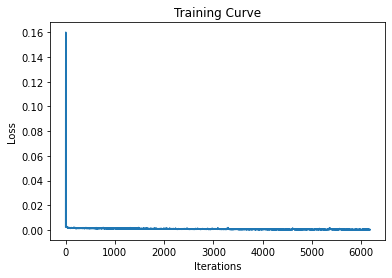

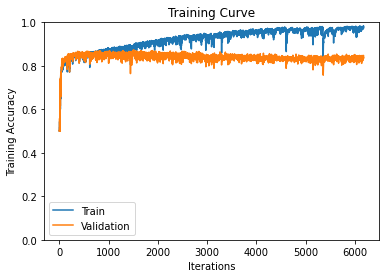

Final Training Accuracy: 0.9755809523809523
Final Validation Accuracy: 0.8357142857142857


In [8]:
alexnet = torchvision.models.alexnet(pretrained=True)

# Transfer learning model with batch_size=256, learning_rate=0.005
model = HappyFaceClassifier_alex()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

# Training
train_updated(model, train_data, val_data, batch_size=256, learning_rate=0.005, num_epochs=30, checkpoint=False, transfer_learning=True, pretrained_model=alexnet)

CUDA is available!  Training on GPU ...


100%|█████████████████████████████████████████| 980/980 [00:18<00:00, 52.16it/s]


Training Started.


  7%|██▋                                      | 1/15 [06:51<1:35:54, 411.01s/it]

Epoch:  0  Train Acc:  0.8003047619047619  Valid Acc:  0.8204081632653061


 13%|█████▍                                   | 2/15 [13:26<1:27:03, 401.83s/it]

Epoch:  1  Train Acc:  0.8437904761904762  Valid Acc:  0.8520408163265306


 20%|████████▏                                | 3/15 [19:06<1:14:42, 373.50s/it]

Epoch:  2  Train Acc:  0.8533333333333334  Valid Acc:  0.8622448979591837


 27%|██████████▉                              | 4/15 [24:22<1:04:21, 351.06s/it]

Epoch:  3  Train Acc:  0.8531428571428571  Valid Acc:  0.8622448979591837


 33%|██████████████▎                            | 5/15 [29:34<56:07, 336.79s/it]

Epoch:  4  Train Acc:  0.845695238095238  Valid Acc:  0.8510204081632653


 40%|█████████████████▏                         | 6/15 [34:45<49:13, 328.11s/it]

Epoch:  5  Train Acc:  0.8673904761904762  Valid Acc:  0.8489795918367347


 47%|████████████████████                       | 7/15 [40:08<43:30, 326.33s/it]

Epoch:  6  Train Acc:  0.8798285714285714  Valid Acc:  0.8704081632653061


 53%|██████████████████████▉                    | 8/15 [45:29<37:52, 324.61s/it]

Epoch:  7  Train Acc:  0.8815238095238095  Valid Acc:  0.8561224489795919


 60%|█████████████████████████▊                 | 9/15 [50:47<32:15, 322.54s/it]

Epoch:  8  Train Acc:  0.881752380952381  Valid Acc:  0.8612244897959184


 67%|████████████████████████████              | 10/15 [56:06<26:47, 321.45s/it]

Epoch:  9  Train Acc:  0.875352380952381  Valid Acc:  0.8418367346938775


 73%|█████████████████████████████▎          | 11/15 [1:01:24<21:22, 320.60s/it]

Epoch:  10  Train Acc:  0.8975619047619048  Valid Acc:  0.8693877551020408


 80%|████████████████████████████████        | 12/15 [1:06:48<16:04, 321.38s/it]

Epoch:  11  Train Acc:  0.9044761904761904  Valid Acc:  0.8459183673469388


 87%|██████████████████████████████████▋     | 13/15 [1:12:07<10:41, 320.66s/it]

Epoch:  12  Train Acc:  0.9032190476190476  Valid Acc:  0.8520408163265306


 93%|█████████████████████████████████████▎  | 14/15 [1:17:24<05:19, 319.76s/it]

Epoch:  13  Train Acc:  0.9241714285714285  Valid Acc:  0.8622448979591837


100%|████████████████████████████████████████| 15/15 [1:22:45<00:00, 331.01s/it]

Epoch:  14  Train Acc:  0.9325523809523809  Valid Acc:  0.860204081632653
Training Finished.
Total time elapsed: 4965.09 seconds


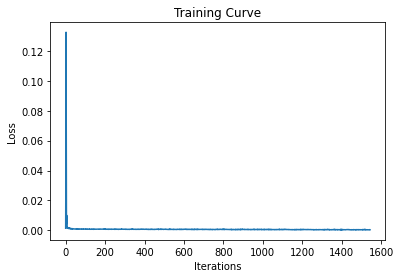

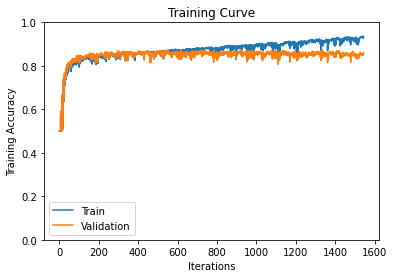

Final Training Accuracy: 0.9325523809523809
Final Validation Accuracy: 0.860204081632653


In [10]:
alexnet = torchvision.models.alexnet(pretrained=True)

# Transfer learning model with batch_size=512, learning_rate=0.005
model = HappyFaceClassifier_alex()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

# Training
train_updated(model, train_data, val_data, batch_size=512, learning_rate=0.005, num_epochs=15, checkpoint=True, transfer_learning=True, pretrained_model=alexnet)